In [1]:
import os, sys
sys.path.append("..")

In [2]:
from tensorized_algorithm import pauli_utils
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from functools import reduce

from qiskit.quantum_info import SparsePauliOp

# Error by applying orders

In the document, we test the Trotter error by applying ordering of each local Hamiltonian.

**Question**

How much error rate is generated, if we apply the commuting partition order, in Trotterization circuit?.

Common error rate of p-th order Trotterization is $O(t^{p+1})$. In "Theory of Trotter Error" paper, they derived a $\alpha$ constant for $O(\alpha t^{p+1})$.


**Observation**

In simple system, $n<3$, the commuting pair errors were 2-10 times larger than random sequence.
However, in larger and complicated systems, $n>4$, the commuting order averagely show good error rates.
The efficiency is getting better as $t$ increases in $\exp(-it H)$.

In [73]:
def mat_diff(A, B):
    U = np.matrix(A - B)
    return 0.5*pauli_utils.fro_inner(U, U)
def matmul(a,b):
    return a@b
def get_U_l(hs, n, t):
    tn = t/n
    us = [expm(-1j*tn*h) for h in hs]
    ut = reduce(matmul, us)
    U = np.eye(ut.shape[0], dtype=complex)
    for i in range(n):
        U @= ut
    return U

In [74]:
N = 4
A = np.random.rand(int(2**N), int(2**N))
T = A.T@A
H = np.matrix((T + 1j*T))
norm_H = 0.5*pauli_utils.fro_inner(H, H)
H *= 1/np.sqrt(norm_H) 


In [75]:
pa = SparsePauliOp.from_operator(H)

In [96]:
pa.group_commuting()

[SparsePauliOp(['IIIX', 'IIXI', 'IIXX', 'IXII', 'IXIX', 'IXXI', 'IXXX', 'XIII', 'XIIX', 'XIXI', 'XIXX', 'XXII', 'XXIX', 'XXXI', 'XXXX', 'IIII'],
               coeffs=[0.24271966+0.24271966j, 0.24753179+0.24753179j, 0.24960353+0.24960353j,
  0.23758192+0.23758192j, 0.24161395+0.24161395j, 0.2306378 +0.2306378j ,
  0.25201204+0.25201204j, 0.23732863+0.23732863j, 0.22770001+0.22770001j,
  0.23617896+0.23617896j, 0.23395049+0.23395049j, 0.23504836+0.23504836j,
  0.23284063+0.23284063j, 0.2243109 +0.2243109j , 0.23661276+0.23661276j,
  0.32831542+0.32831542j]),
 SparsePauliOp(['IIIZ', 'IIXZ', 'IXIZ', 'IXXZ', 'XIIZ', 'XIXZ', 'XXIZ', 'XXXZ'],
               coeffs=[ 0.00772981+0.00772981j, -0.00546614-0.00546614j,  0.0104224 +0.0104224j ,
   0.01368442+0.01368442j, -0.00552647-0.00552647j,  0.00929812+0.00929812j,
   0.00928367+0.00928367j, -0.00304383-0.00304383j]),
 SparsePauliOp(['IIYY', 'IIZX', 'IXYY', 'IXZX', 'XIYY', 'XIZX', 'XXYY', 'XXZX'],
               coeffs=[-0.0333962 -0.0333962j

In [77]:
Hs = pa.matrix_iter()
H_com_group = [h.to_matrix() for h in pa.group_commuting()]

In [78]:
len(Hs), len(H_com_group)

(136, 21)

In [79]:
pauli_utils.fro_inner(np.matrix(H), np.matrix(H))/2

(1-6.5673615583935655e-19j)

In [80]:
identit_index = [i for i in range(len(H_com_group))]
random_index = [i for i in range(len(Hs))]
shuffle(random_index)

In [81]:
def get_U_n(hs, n, t, rand_index): #get general order u
    tn = t/n    
    us = [np.matrix(expm(-1j*tn*hs[i])) for i in rand_index]
    ut = reduce(matmul, us)
    U = np.eye(ut.shape[0], dtype=complex)
    for i in range(n):
        U @= ut
    return U


In [82]:
n = 5
t = 0.4
U = expm(-1j*t*H)
Ug = get_U_n(Hs, n, t, random_index)
Uc = get_U_n(H_com_group, n, t, identit_index)

##

$$U \approx $$

$$U_1 U_2 U_3,$$


$$U_2 U_3 U_1,$$


$$U_3 U_2 U_1,$$


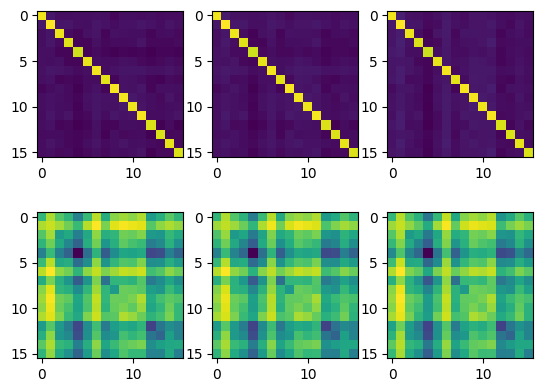

In [83]:
fig, axes = plt.subplots(2, 3)
axes[0, 0].imshow(U.real)
axes[1, 0].imshow(U.imag)

axes[0, 1].imshow(Ug.real)
axes[1, 1].imshow(Ug.imag)

axes[0, 2].imshow(Uc.real)
axes[1, 2].imshow(Uc.imag)

In [84]:
mat_diff(U, Ug).real, mat_diff(U, Uc).real

(0.00019319175149322578, 0.001442052200995342)

In [85]:
from copy import deepcopy

In [86]:
from opttrot.pauli_utils import pstr_commute

In [46]:
n = 4
errs = []
ts = np.linspace(0.8, 1.4, 50)
pplist = pa.to_list()
max_i = len(Hs)

for t in ts:
    U = expm(-1j*t*H)
    err_coms = []
    iter1 = 2000
    for i in range(iter1):
        shuffle(H_com_group)
        Uc = get_U_n(H_com_group, n, t, identit_index)
        err_com = mat_diff(U, Uc)
        err_coms.append(err_com)
    
    err = []
    min_err = err_com 
    optimal_index = None
    iter2 = 5000
    for l in range(iter):
        random_index = [i for i in range(len(Hs))]
        shuffle(random_index)
        Ug = get_U_n(Hs, n, t, random_index)
        err_c =mat_diff(U, Ug).real
        err.append(err_c)
        if min_err > err_c :
            optimal_index = deepcopy(random_index)
            min_err = err_c
    
    if optimal_index is not None:
        commute = []
        for i, j in enumerate(optimal_index):
            if i +1 >= max_i:
                break
            p1 = pplist[j][0]
            p2 = pplist[optimal_index[i+1]][0]
            commute.append(pstr_commute(p1, p2))
        commute = np.array(commute)
        M = max_i-1
        commute_num = commute.sum()
        cn = commute_num/M
        acn = 1-cn
        print(f"Commute ratio: {cn:.2}/{acn:.2}")
        print(commute)
    
    e_max = max(err)
    e_min = min(err)
    percentage = (100*(np.abs(min(err_coms)))/e_max).real
    errs.append(percentage)
    print(f"{n}, {t:.3}", f"{percentage:.2}%", )

KeyboardInterrupt: 

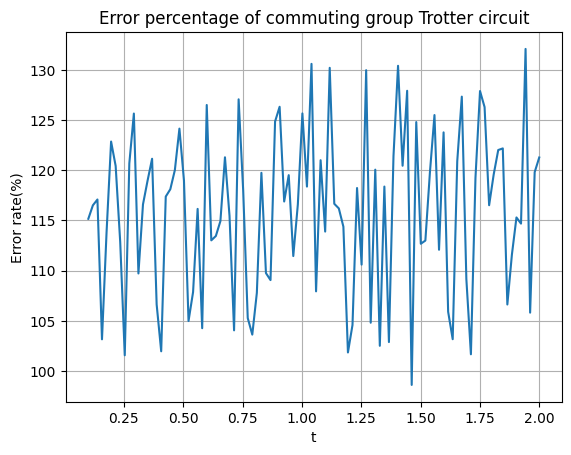

In [18]:
plt.plot(ts[:len(errs)], errs[-len(errs):])
plt.title("Error percentage of commuting group Trotter circuit")
plt.xlabel("t")
plt.ylabel("Error rate(%)")
plt.grid()

In [91]:
from copy import deepcopy

In [92]:
t = 0.9
n = 4
U = expm(-1j*t*H)

err_coms = []
index_min = None
for i in range(1000):
    index_com = [i for i in range(len(H_com_group))]
    shuffle(index_com)
    Uc = get_U_n(H_com_group, n, t, index_com)
    err_com = mat_diff(U, Uc)
    err_coms.append(err_com)
    if err_com <= min(err_coms):
        index_min = deepcopy(index_com)
err_com = min(err_coms)


err = []
min_err = err_com 
optimal_index = None
iter1 = 5000
for l in range(iter1):
    random_index = [i for i in range(len(Hs))]
    shuffle(random_index)
    Ug = get_U_n(Hs, n, t, random_index)
    err_c =mat_diff(U, Ug).real
    err.append(err_c)
    if min_err > err_c :
        optimal_index = deepcopy(random_index)
        min_err = err_c
    
e_max = max(err)
e_min = min(err)
percentage = (100*(err_com - e_min)/e_max).real

In [93]:
percentage

36.28363159409261

In [95]:
index_min 

[16, 18, 2, 15, 1, 4, 8, 6, 9, 17, 13, 19, 0, 12, 11, 3, 5, 14, 20, 7, 10]

/Users/hyunseongkim/miniconda3/envs/opttrot/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


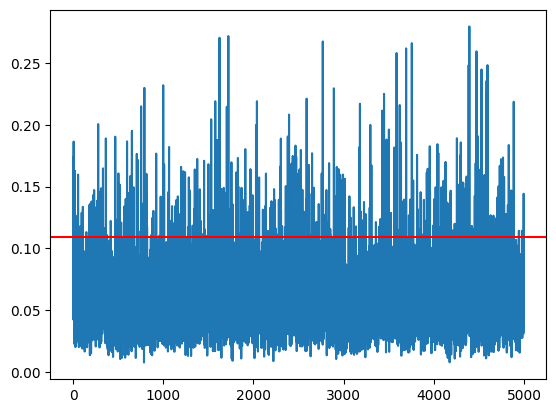

In [94]:
plt.plot(err)
plt.axhline(err_com, 0, iter, c="r")

In [67]:
min_err

0.013138065863168406

In [71]:
U.shape

(16, 16)

In [864]:
from opttrot.pauli_utils import pstr_commute

In [870]:
pplist = pa.to_list()
max_i = len(optimal_index)
print(max_i)
commute = []
for i, j in enumerate(optimal_index):
    if i +1 >= max_i:
        break

    pa = pplist[j][0]
    pb = pplist[optimal_index[i+1]][0]

    commute.append(pstr_commute(pa, pb))
commute = np.array(commute)

135


In [873]:
commute

array([False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True,  True, False, False, False,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False, False,  True, False, False, False,
        True,  True,  True, False,  True, False, False,  True,  True,
       False, False,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True, False, False, False,
        True, False,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False, False,  True, False,
        True,  True,

In [876]:
commute.sum()/(max_i-1), (max_i-1 -commute.sum())/(max_i-1)

(0.5, 0.5)